# Multi-class Image Classification

The prior exercise did the following steps with binary classification (pizza vs steak), now we're goiing to do 10 classes of food (multi class classification).

* 1. Become one with the data
* 2. Preprocess the data (get it ready for a model)
* 3. Create a model (start with a baseline)
* 4. Fit the model (overfit it to make sure it works)
* 5. Evaluate the model
* 6. Adjust different hyperparameters and improve the model (try to beat the baseline/reduce overfitting)


In [1]:
#Import sklearn before tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import pathlib
import numpy as np
import random
import urllib.request

In [2]:
print(tf.__version__), sys.version, sklearn.show_versions()

2.4.1

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True
C:\Users\timar\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


(None,
 '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]',
 None)

# Test for Tensorflow GPU Support

GPU setup is documented here: https://www.tensorflow.org/install/gpu

In [3]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
# See if we have a GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("No GPU detected or you need to install the GPU version of tensorflow using pip install tensorflow-gpu.")

Default GPU Device:/device:GPU:0


# Download and Unzip the Data

* The source data set is from the [Kaggle Food 101 Data Set](https://www.kaggle.com/dansbecker/food-101)
* Daniel modified the data set [using this script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).
* The zip file we use in this notbnook [is here](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip).


In [5]:
#Setup variables for our data
if os.name == "nt":
    zip_download_file = "c:/temp/data/10_food_classes_all_data/10_food_classes_all_data.zip"
    zip_extract_location = "c:/temp/data/10_food_classes_all_data/"
    data_dir = "c:/temp/data/10_food_classes_all_data/10_food_classes_all_data"
else:
    zip_download_file = "/home/pi/Dev/data/10foodclasses/10_food_classes_all_data.zip"
    zip_extract_location = "/home/pi/Dev/data/10_food_classes_all_data/"
    data_dir = "/home/pi/Dev/data/10_food_classes_all_data/10_food_classes_all_data"

train_data_dir = data_dir + "/train"
test_data_dir = data_dir + "/test"

In [6]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
#if not os.path.isfile(zip_download_file):
#    !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip -O $zip_download_file

In [7]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
if not os.path.exists(data_dir):
    zip_ref = zipfile.ZipFile(zip_download_file)
    zip_ref.extractall(path=zip_extract_location)
    zip_ref.close()

In [8]:
# Walk through the data directory and list number of files
# The extra file in our data directory is .DS_Store
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data
There are 10 directories and 0 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\chicken_curry
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\chicken_wings
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\fried_rice
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\grilled_salmon
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\hamburger
There are 0 directories and 250 images in c:/temp/data/10_food_classes_all_data/10_food_classes_all_data\test\ice_cream
There are 0 directories and 250 images in c:/temp/data

In [9]:
 # Another way to find out how many images are in a directory
 num_sushi_images_train = len(os.listdir(data_dir+"/train/sushi"))
 num_sushi_images_train

750

# 1. Visualize our Images

In [10]:
train_data_dir_path = pathlib.Path(train_data_dir)
for item in train_data_dir_path.glob("*"):
    print(item)

c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\chicken_curry
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\chicken_wings
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\fried_rice
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\grilled_salmon
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\hamburger
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\ice_cream
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\pizza
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\ramen
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\steak
c:\temp\data\10_food_classes_all_data\10_food_classes_all_data\train\sushi


In [11]:
# To visualize our imaages, first lets get our class names programatically
train_data_dir_path = pathlib.Path(data_dir+"/train/")
# Create a list of class names from the subdirectories
class_names = np.array(sorted([item.name for item in train_data_dir_path.glob("*")]))
#class_names = np.delete(class_names, np.where(class_names == ".DS_Store"))
print(class_names), len(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


(None, 10)

In [12]:
# Lets visualize our images
def view_random_images(target_dir, class_names, class_to_show=None, num_images=4, figsize=(10,10)):
    
    plt.figure(figsize=figsize)
    for i in range(num_images):
        # If a class was specified then show only that class
        if class_to_show:
            selected_class = class_to_show
        # Otherwise randomly pick classes
        else:
            selected_class = random.choice(class_names)

        # Setup the target directory (we'll view images from here)
        target_folder = target_dir + "/" + selected_class

        plt.subplot(1, num_images, i+1)

        #Get a random image path
        random_image = random.sample(os.listdir(target_folder), 1)
        
        # Read in the image and plot it using matplotlib
        img = mpimg.imread(target_folder + "/" + random_image[0])
        plt.imshow(img)
        plt.title(f"{selected_class}\nShape: {img.shape}\nFile: {random_image[0]}")
        plt.axis("off")

        print(f"Image Shape: {img.shape}")
        #return img

Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)
Image Shape: (512, 512, 3)


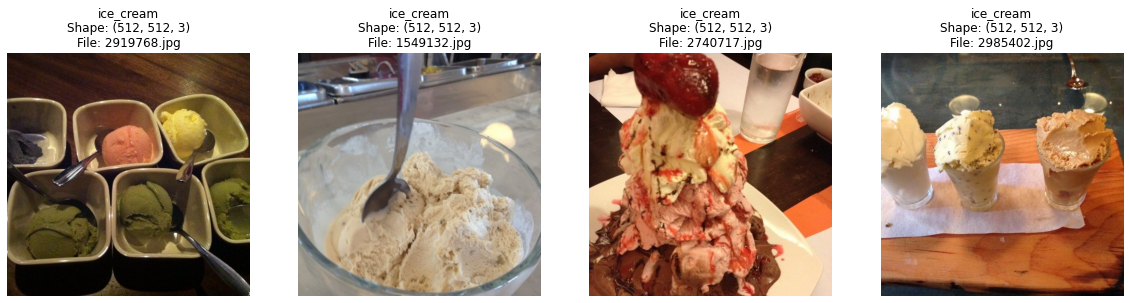

In [13]:
# View a random image from the training data set
view_random_images(
    target_dir=train_data_dir, 
    class_names = class_names,
    class_to_show = random.choice(class_names),
    num_images=4,
    figsize=(20,20)
)

# 2. Preprocess our Images

In [14]:
# Set the seed for reproducibility
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data in from directories and turn it into batches
# Setup paths to our data directories
# Use these variables extablished above
# train_data_dir
# test_data_dir

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size = 32,
    # Reshape all the images to be the same size. 
    target_size = (224, 224),
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    batch_size = 32,
    # Reshape all the images to be the same size. 
    target_size = (224, 224),
    class_mode = "categorical", # categorical (2d one hot encoded labels) or binary
    seed = 42
)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [15]:
# Get a sample of train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [16]:
# How many batches are there
len(train_data) # This equals 1500 images divided by batch size of 32, rounded up

235

Showing image number 7


(-0.5, 223.5, 223.5, -0.5)

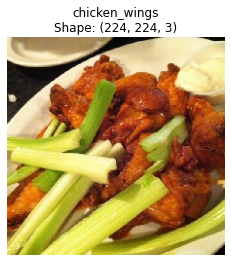

In [17]:
# Show a random image and its label from our Image Generator/Loader
import random
# Return a number between 0 and the length of our images array (both included)
random_number = random.randint(0, len(images)-1)
label_index = np.argmax(labels[random_number])
print(f"Showing image number {random_number}")
image_shape = images[random_number].shape
plt.imshow(images[random_number])
plt.title(f"{class_names[label_index]}\nShape: {image_shape}")
plt.axis(False)

# 3. Create a Model (start with a baseline)

## Breakdown of a Conv2D layer
* Filters: Decides how many filters should pass over an input tensor (eg sliding windows over an image). Typical values are 10, 32, 64. The more filters you have, the more complex your model is.
* Kernel Size (also called filter size): Determines the shape of the filters (sliding windows) over the output. Common values are 3, 5, 7 (lower values learn smaller more fine grained features, higher values learn larger features) (i.e., lower values might identify toppings on a pizza, while a larger value might recognize the edges of a pizza)
* Padding: pads the tensor with zeroes (if "same") to preserve input shape. Or leaves the target tensor as is (if "valid"), lowering output shape. You might use padding to better learn features near the edges of your image.
* Strides: The number of steps a filter takes across an image at a time. (eg, if strides = 1, a filter moves across an image 1 pixel at a time)

In [18]:
tf.random.set_seed(42)

# Create a model with same structure as CNN Explainer website: https://poloclub.github.io/cnn-explainer/
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=(224,224,3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile our model
model_1.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_1 = model_1.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
235/235 [==============================] - 53s 215ms/step - loss: 2.1892 - accuracy: 0.1874 - val_loss: 2.0044 - val_accuracy: 0.3092
Epoch 2/5
235/235 [==============================] - 17s 71ms/step - loss: 1.8519 - accuracy: 0.3644 - val_loss: 1.8587 - val_accuracy: 0.3448
Epoch 3/5
235/235 [==============================] - 17s 71ms/step - loss: 1.4480 - accuracy: 0.5145 - val_loss: 1.9580 - val_accuracy: 0.3408
Epoch 4/5
235/235 [==============================] - 17s 71ms/step - loss: 0.8752 - accuracy: 0.7327 - val_loss: 2.3173 - val_accuracy: 0.3128
Epoch 5/5
235/235 [==============================] - 17s 71ms/step - loss: 0.3413 - accuracy: 0.9009 - val_loss: 3.5063 - val_accuracy: 0.2976


# 4. Evaluating our Model

* Note: When a models **validation loss** starts to increase it's likely that the model is **overfitting**. This means it's learning the patterns in the training dataset too well and thus the model's ability to generalize unseen data will be diminished.

In [19]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"])) # how many epochs did we train for

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot Accuracy
    plt.figure() #Start a new plot figure
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

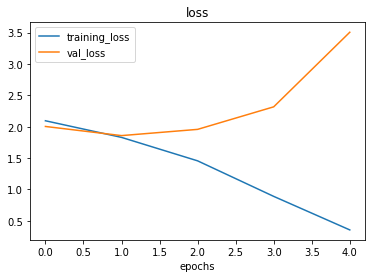

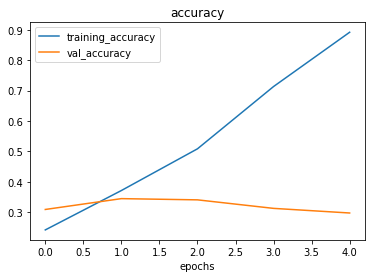

In [20]:
# Checkout the loss and accuracy of model 4
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
plot_loss_curves(history_1)

# Make a prediction on a test image


In [21]:
# Create a function to import our image, and resize it to be able to be used with our model
def load_and_prep_image(url, img_shape=224):
    """
    Reads an image from filename, and turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
    """
    # Read in the image
    #img = tf.io.read_file(filename)
    image_request = urllib.request.urlopen(url)
    img = image_request.read()
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

In [27]:
def predict_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model, and plots the image with the predicted class as the title.
    """
    #Import the target images and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    print(pred)

    # Get the predicted class
    if len(class_names) <= 2:
        # For binary:
        pred_class = class_names[int(tf.round(pred))]
    else:
        # For multiclass:
        pred_class = class_names[np.argmax(pred)]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

[[2.0690425e-06 9.9821448e-01 5.7489519e-08 3.1329553e-05 3.5787663e-05
  2.0476880e-07 3.0465267e-04 1.2499923e-03 1.6141974e-04 3.2013364e-08]]


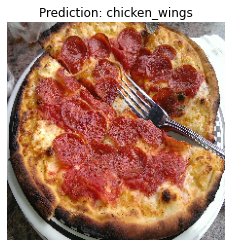

In [32]:
#Steak
#predict_and_plot(model_1, "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg")

#Pizza
predict_and_plot(model_1, "https://upload.wikimedia.org/wikipedia/commons/1/10/Pepperoni_pizza.jpeg")

#Pizza
#predict_and_plot(model_1, "https://www.hungryhowies.com/sites/default/files/styles/menu_item_280x175/public/images/menu-items/thumbnails/buildyourownpizza_0.png?itok=fgzFck86")